In [ ]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using CoordinateTransformations
using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Printf
using LinearAlgebra
using Plots
using Trapz
import ForwardDiff as FD
using ProgressMeter
import Convex as cvx
import ECOS
using GeometryBasics
using ColorTypes

# include(joinpath(@__DIR__, "zoe2.jl"))
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "planner.jl"))


  Activating project at `~/cmu/courses/16745_OCRL/zoe2_optimal_controller/julia`
   Resolving package versions...
    Updating `~/cmu/courses/16745_OCRL/zoe2_optimal_controller/julia/Project.toml`
⌅ [3da002f7] + ColorTypes v0.11.5
  No Changes to `~/cmu/courses/16745_OCRL/zoe2_optimal_controller/julia/Manifest.toml`


main (generic function with 1 method)

## Set up Parameters

In [2]:
# points = [
#     [0.0, 0.0],
#     [4.0, 5.0],
#     [-4.0, 15.0],
#     [0.0, 20.0],
#     [10.0, 15.0],
#     [-5.0, 12.0]
# ]

points = [
    [0.0, 0.0],
    [4.0, 5.0],
    [-4.0, 15.0],
    [0.0, 20.0]
]

v_b = 1 # nominal body speed for the rover [m/s]
dt = .1 # period of updates [s]
r = 0.325 # wheel radius [m]
L = 1.91 # Length between axle pivot points [m]
B = 1.64 # Width of axles [m]

input_params = (v_b = v_b, dt = dt, r = r, L=L, B=B)

(v_b = 1, dt = 0.1, r = 0.325, L = 1.91, B = 1.64)

## Trajectory Preview

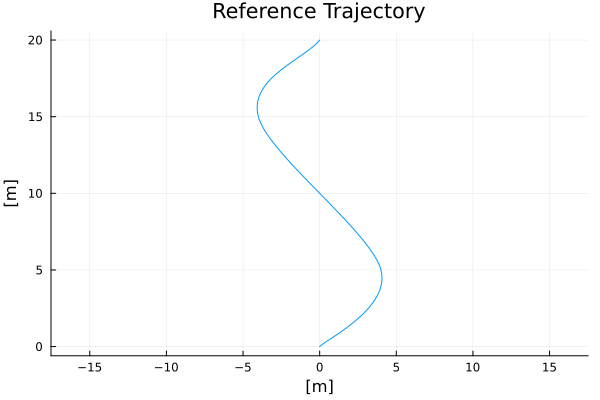

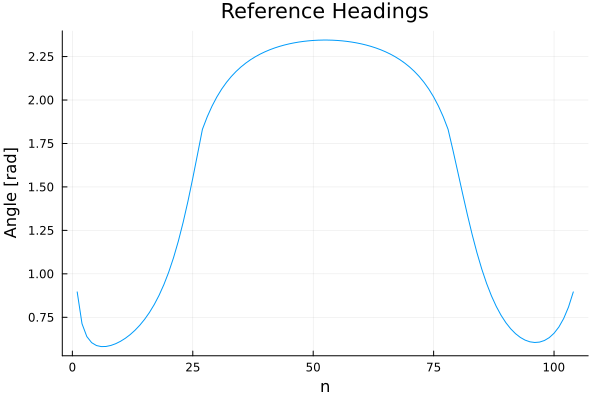

Segment length: 6.801948114390082
Num pts in Segment: 27
Segment length: 12.899964517693888
Num pts in Segment: 52
Segment length: 6.810026807779111
Num pts in Segment: 27


In [3]:
#previews trajectory.  Not needed to run
# points = [
#     [0.0, 0.0],
#     [4.0, 5.0],
#     [-4.0, 15.0],
#     [0.0, 20.0],
#     [10.0, 15.0],
#     [-5.0, 12.0]
# ]

params = (v_b=25,
        dt=.01,
        r=0.325,
        L=1.91,
        B=1.64)

Xref, Uref = generate_trajectory(points, params) 
# println(Xref)
# println(Uref)

x_pos = [Xref[i][1] for i in 1:length(Xref)]
y_pos = [Xref[i][2] for i in 1:length(Xref)]
headings = [Xref[i][3] for i in 1:length(Xref)]

display(plot(x_pos,y_pos,label="",xlabel = "[m]", ylabel = "[m]",title = "Reference Trajectory"; aspect_ratio=:equal))
display(plot(headings,label="",xlabel = "n", ylabel = "Angle [rad]",title = "Reference Headings"))

In [4]:
function dynamics(params::NamedTuple, x::Vector, u::Vector)
    # ODE, parametrized by params

    # physical parameters 
    r, L, B = params.r, params.L, params.B
    ωfl, ωfr, ωrl, ωrr = u
    xb, yb, ψb, θf, θr = x
    
    vf = r/2*(ωfl + ωfr)
    vr = r/2*(ωrl + ωrr)
    vb = 0.5*(vf/cos(θr) + vr/cos(θf)) * sqrt(cos(θr)*cos(θf)*cos(θf+θr) + 0.25*(sin(θf+θr))^2)

    xdot = [vb*cos(ψb);
            vb*sin(ψb);
            sin(θf+θr)/(2*L)*(vf/cos(θr) + vr/cos(θf));
            r/B*(ωfr - ωfl);
            r/B*(ωrl - ωrr)]

    return xdot
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    #hermite simpson implicit integrator residual 

    xm = 0.5*(x1 + x2) + (dt/8)*(dynamics(params,x1,u) - dynamics(params,x2,u))
    residual = x1 + (dt/6)*(dynamics(params,x1,u) + 4*dynamics(params,xm,u) +
        dynamics(params,x2,u)) - x2
    
    return residual

end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

In [5]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

# return a scalar 
function cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N
    Q, R, Qf = params.Q, params.R, params.Qf
    Xref, xg = params.Xref, params.xg

    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        # J += 0.5*(xi-xg)'*Q*(xi-xg) + 0.5*ui'*R*ui
        J += 0.5*(xi-Xref[i])'*Q*(xi-Xref[i]) + 0.5*ui'*R*ui
    end
    
    #terminal cost 
    xN = Z[idx.x[N]]
    J += 0.5*(xN-Xref[N])'*Qf*(xN-Xref[N])

    return J
end

function dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    #create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # hermite simpson 
        #x1 is x_k,  x2 is x_k+1 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end

    return c 
end

function equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    #return all of the equality constraints (dynamics, IC, and goal)  IC and goal constraints only enforced for x and y body position
    return [dynamics_constraints(params,Z); Z[idx.x[1]][1:3] - xic; Z[idx.x[N]][1:2] - xg]

end


function solve_trajOpt(Xref, Uref, input_params, ;verbose=true)
    
    # Xref, Uref = generate_trajectory(points, ref_traj_params) 
    v_b = input_params.v_b
    dt = input_params.dt
    r = input_params.r
    L = input_params.L
    B = input_params.B

    # problem size 
    nx = 5
    nu = 4 
    N = length(Xref)


    tf = (N-1)*dt
    t_vec = 0:dt:tf  #check dims match up

    # LQR cost 
    Q = 5*diagm([1;1;.5;.1;.1])
    R = 0.05*diagm(ones(nu))
    Qf = 40*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states.  Only enforce for x and y body position
    xic = Xref[1][1:3] ###############################
    xg = Xref[N][1:2]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, 
            N = N, idx = idx, r = r, L = L, B = B, Xref = Xref)
    
    # primal bounds 
    # x_l = 
    # x_u =  
    ####
    x_l = -Inf* ones(idx.nz)
    x_u = Inf* ones(idx.nz)

    # uidx = [collect(r)[1] for r in idx.u] #makes array of all u indices

    #can set wheel velocity constraints here
    # x_l[uidx] .= -100
    # x_u[uidx] .= 100

    for i in 1:(N-1)
        x_l[idx.u[i]] .= -4
        x_u[idx.u[i]] .= 4

        x_l[idx.x[i][4:5]] .= -25 *pi/180
        x_u[idx.x[i][4:5]] .= 25 *pi/180
    end
    x_l[idx.x[N][4:5]] .= -25 *pi/180
    x_u[idx.x[N][4:5]] .= 25 *pi/180

    # display(uidx)
    # display(x_l)

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)

    for i in 1:(N-1)
        z0[idx.x[i]] = Xref[i]
        z0[idx.u[i]] = Uref[i]
    end
    z0[idx.x[N]] = Xref[N]

    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
    # diff_type = :finite
    
    # println(z0[idx.x[1]][1:2])
    
    Z = fmincon(cost, equality_constraint, inequality_constraint,
                x_l, x_u, c_l, c_u, z0, params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end



solve_trajOpt (generic function with 1 method)

## Run DIRCOL

Segment length: 6.801948114390082
Num pts in Segment: 68
Segment length: 12.899964517693888
Num pts in Segment: 129
Segment length: 6.810026807779111
Num pts in Segment: 68
---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3

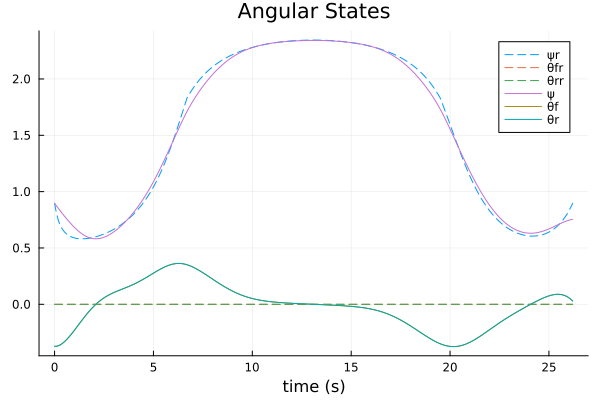

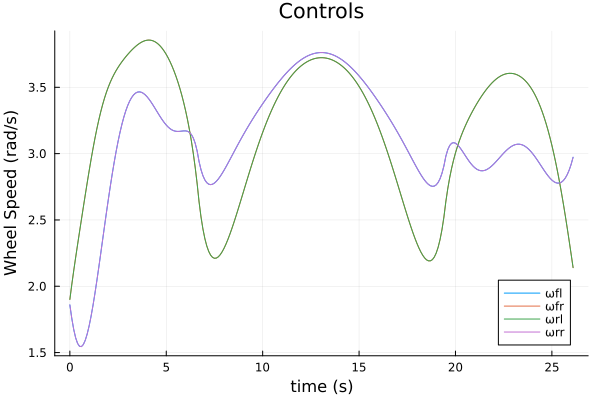

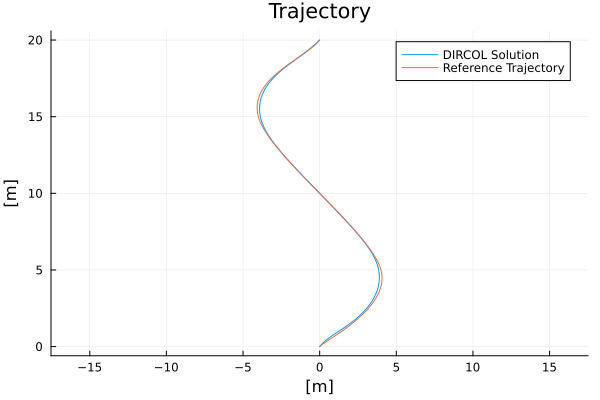

In [6]:
#waypoints.  Should be able to add whatever to create the desired path
# points = [
#     [0.0, 0.0],
#     [4.0, 5.0],
#     [-4.0, 15.0],
#     [0.0, 20.0]
# ]

# points = [
#     [0.0, 0.0],
#     [4.0, 5.0],
#     [-4.0, 15.0],
#     [0.0, 20.0],
#     [10.0, 15.0],
#     [-5.0, 12.0]
# ]

# v_b = 1 # nominal body speed for the rover [m/s]
# dt = .1 # period of updates [s]
# r = 0.325 # wheel radius [m]
# L = 1.91 # Length between axle pivot points [m]
# B = 1.64 # Width of axles [m]

# input_params = (v_b = v_b, dt = dt, r = r, L=L, B=B)

Xref, Uref = generate_trajectory(points, input_params) 

X_dirc, U_dirc, t_vec = solve_trajOpt(Xref, Uref, input_params, verbose = true)
Xm = hcat(X_dirc...)
Um = hcat(U_dirc...)

Xrefm = hcat(Xref...)
Urefm = hcat(Uref...)

plot(t_vec, Xrefm[3:end,:]', ls = :dash, label=["ψr" "θfr" "θrr" ])
display(plot!(t_vec, Xm[3:end,:]', label = ["ψ" "θf" "θr" ], xlabel = "time (s)", 
        title = "Angular States"))

# plot(t_vec, Xrefm', ls = :dash, label=["xr" "yr" "ψr" "θfr" "θrr" ])
# display(plot!(t_vec, Xm', label = ["x" "y" "ψ" "θf" "θr" ], xlabel = "time (s)", 
#         title = "State Trajectory"))


display(plot(t_vec[1:end-1],Um',label = ["ωfl" "ωfr" "ωrl" "ωrr"], xlabel = "time (s)", ylabel = "Wheel Speed (rad/s)",title = "Controls"))

x_ref_pos = [Xref[i][1] for i in 1:length(Xref)]
y_ref_pos = [Xref[i][2] for i in 1:length(Xref)]

x_dir_pos = [X_dirc[i][1] for i in 1:length(X_dirc)]
y_dir_pos = [X_dirc[i][2] for i in 1:length(X_dirc)]

plot(x_dir_pos,y_dir_pos,label="DIRCOL Solution", xlabel = "[m]", ylabel = "[m]",title = "Trajectory"; aspect_ratio=:equal)
display(plot!(x_ref_pos,y_ref_pos,label="Reference Trajectory"))


### View Animation

In [ ]:
include(joinpath(@__DIR__, "zoe2.jl"))

vis = Visualizer()
# open(vis)  # open the visualizer in a separate tab/window
render(vis) # render the visualizer here inside the jupyter notebook

urdf_path = joinpath(@__DIR__, "zoe2.urdf")
robot = parse_urdf(urdf_path)
mvis = MechanismVisualizer(robot, URDFVisuals(urdf_path), vis)

# Create a state for the mechanism
state = MechanismState(robot)
q = configuration(state)

println("Initial configuration vector:")
println(q)
println("Number of degrees of freedom: ", length(q))

# Iterate over the joints to print their names
for (i, joint) in enumerate(joints(robot))
    println("Joint ", i, ": ", joint.name)
end

# Example: update a joint value
# q[2] = 0.3
# q[3] = -0.3

# Update the visualizer with the new configuration
set_configuration!(mvis, q)

# state = MechanismState(robot, randn(2), randn(2))
# t, q, v = simulate(state, 5.0);

# Print out the states at each time step
# for i in 1:length(X_dirc)
#     println("X: ", round(X_dirc[i][1], digits=3), " Y: ", round(X_dirc[i][2], digits=3), " Heading: ", round(X_dirc[i][3] - π/2, digits=3))
# end

animate_zoe2(X_dirc, input_params.dt, Xref=Xref)

Initial configuration vector:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of degrees of freedom: 7

┌ Info: Listening on: 127.0.0.1:8771, thread id: 1
└ @ HTTP.Servers /home/hayden/.julia/packages/HTTP/4AUPl/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8771
└ @ MeshCat /home/hayden/.julia/packages/MeshCat/9QrxD/src/visualizer.jl:43
┌ Info: Listening on: 127.0.0.1:8772, thread id: 1
└ @ HTTP.Servers /home/hayden/.julia/packages/HTTP/4AUPl/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8772
└ @ MeshCat /home/hayden/.julia/packages/MeshCat/9QrxD/src/visualizer.jl:43


t length: 263


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dot_25" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_238" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x33, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x33, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_201" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x30, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x30, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_230" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x33, 0x30], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x33, 0x30], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_68" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x36, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x36, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_262" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x36, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x36, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x32, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_57" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x35, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x35, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_38" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x33, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x64, 0x6f, 0x74, 0x5f, 0x33, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "dot_153" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6,

In [52]:

# display(X)
θf = [X_dirc[i][4] for i = 1:size(X,1)]

display(maximum(θf)*180/pi) #maximum axis angle acheived by front axle (radians)


20.77740068577462

## TVLQR section

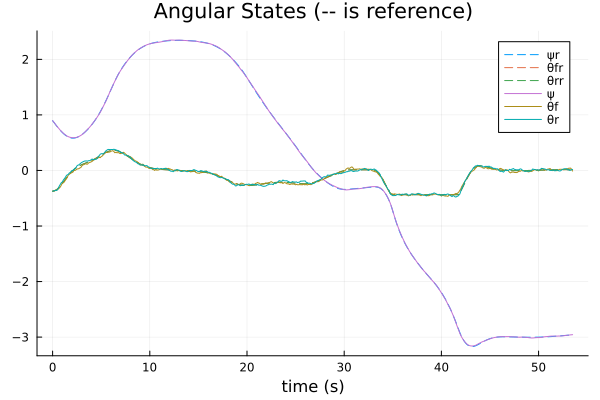

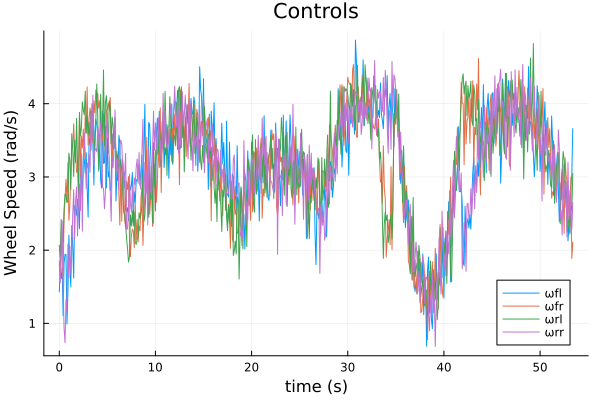

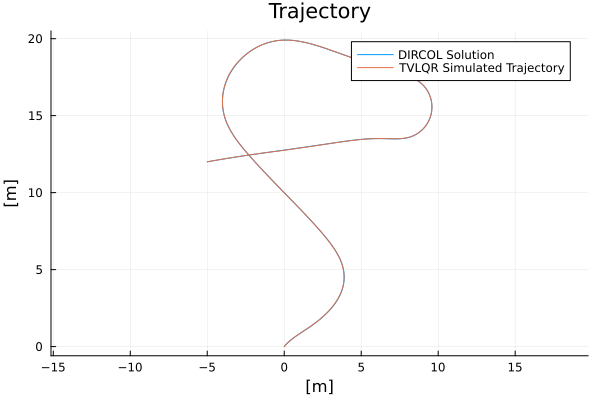

In [129]:
# optimized trajectory we are going to try and track is X_dirc, U_dirc
# DATA = load(joinpath(@__DIR__,"swingup.jld2"))
# Xbar = DATA["X"]
# Ubar = DATA["U"]

# states and controls 
nx = length(X_dirc[1])
nu = length(U_dirc[1])
N = length(X_dirc)

# problem size 
tf = (N-1)*dt #dt defined above
t_vec = 0:dt:tf  

# LQR cost terms
Q = 5*diagm([1;1;.5;.1;.1])
R = 0.05*diagm(ones(nu))
Qf = 40*diagm(ones(nx))

# states (initial condition of zeros)
X = [zeros(nx) for i = 1:N]
X[1] = X_dirc[1]

U = [zeros(nu) for i = 1:(N-1)]

# make sure we have the same initial condition 
# @assert norm(X[1] - X_dirc[1]) < 1e-12

# real and estimated params 
# params_est = (mc = 1.0, mp = 0.2, l = 0.5)
# params_real = (mc = 1.2, mp = 0.16, l = 0.55)

# TODO: design a time-varying LQR controller to track this trajectory 
# use params_est for your control design, and params_real for the simulation

# TODO: solve for tvlqr gains K

####
P = [zeros(nx,nx) for i = 1:N]
K = [zeros(nu,nx) for i = 1:N-1]

P[N] = deepcopy(Qf)
for k = N-1:-1:1

    A = FD.jacobian(_x -> rk4(input_params, _x, U_dirc[k], dt),X_dirc[k])
    B = FD.jacobian(_u -> rk4(input_params, X_dirc[k], _u, dt),U_dirc[k])

    K[k] = (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
    P[k] = Q + A'*P[k+1]*(A - B*K[k])
end
####

# TODO: simulate this controlled system with rk4(params_real, ...)

####
for k=1:N-1
    U[k] = -K[k]*(X[k]-X_dirc[k])+U_dirc[k] + .3*randn(nu)#+ .1*randn(nu) #

    X[k+1] = rk4(input_params, X[k], U[k], dt) #should simulate with noise

    # X[k+1] = X[k+1] + 0.1*randn(nx)
end
####
    
# ---------------tests and plots/animations---------------
xn = X[N]
# @test norm(xn)>0
# @test 1e-6<norm(xn - X_dirc[end])<.2
# @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 

Xm = hcat(X...)
X_dircm = hcat(X_dirc...)

Um = hcat(U...)
# plot(t_vec, X_dircm', ls=:dash, label = ["x" "y" "ψ" "θf" "θr" ])
# display(plot!(t_vec,Xm',title = "States (-- is reference)",
#                 xlabel = "time(s)", ylabel = "Values",
#                 label = ["x" "y" "ψ" "θf" "θr" ]))#,lc = [:red :green :blue :black]))

# display(plot(t_vec[1:end-1],Um',label = ["ωfl" "ωfr" "ωrl" "ωrr"], xlabel = "time (s)", ylabel = "Wheel Speed (rad/s)",title = "Controls"))


#

plot(t_vec, X_dircm[3:end,:]', ls = :dash, label=["ψr" "θfr" "θrr" ])
display(plot!(t_vec, Xm[3:end,:]', label = ["ψ" "θf" "θr" ], xlabel = "time (s)", 
        title = "Angular States (-- is reference)"))

# plot(t_vec, Xrefm', ls = :dash, label=["xr" "yr" "ψr" "θfr" "θrr" ])
# display(plot!(t_vec, Xm', label = ["x" "y" "ψ" "θf" "θr" ], xlabel = "time (s)", 
#         title = "State Trajectory"))


display(plot(t_vec[1:end-1],Um',label = ["ωfl" "ωfr" "ωrl" "ωrr"], xlabel = "time (s)", ylabel = "Wheel Speed (rad/s)",title = "Controls"))

x_ref_pos = [X[i][1] for i in 1:length(X)]
y_ref_pos = [X[i][2] for i in 1:length(X)]

x_dir_pos = [X_dirc[i][1] for i in 1:length(X_dirc)]
y_dir_pos = [X_dirc[i][2] for i in 1:length(X_dirc)]

plot(x_dir_pos,y_dir_pos,label="DIRCOL Solution", xlabel = "[m]", ylabel = "[m]",title = "Trajectory"; aspect_ratio=:equal)
display(plot!(x_ref_pos,y_ref_pos,label="TVLQR Simulated Trajectory"))


# animation stuff
# display(animate_cartpole(X, dt))
# ---------------tests and plots/animations---------------


### View Animation

In [37]:
vis = Visualizer()
# open(vis)  # open the visualizer in a separate tab/window
render(vis) # render the visualizer here inside the jupyter notebook

urdf_path = joinpath(@__DIR__, "zoe2.urdf")
robot = parse_urdf(urdf_path)
mvis = MechanismVisualizer(robot, URDFVisuals(urdf_path), vis)

# Create a state for the mechanism
state = MechanismState(robot)
q = configuration(state)

println("Initial configuration vector:")
println(q)
println("Number of degrees of freedom: ", length(q))

# Iterate over the joints to print their names
for (i, joint) in enumerate(joints(robot))
    println("Joint ", i, ": ", joint.name)
end

# Example: update a joint value
# q[2] = 0.3
# q[3] = -0.3

# Update the visualizer with the new configuration
set_configuration!(mvis, q)

# state = MechanismState(robot, randn(2), randn(2))
# t, q, v = simulate(state, 5.0);

animate_zoe2(X, input_params.dt)

Initial configuration vector:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of degrees of freedom: 7
Joint 1: axle_roll_back_joint
Joint 2: axle_yaw_front_joint
Joint 3: axle_yaw_back_joint
Joint 4: wheel_front_right_joint
Joint 5: wheel_front_left_joint
Joint 6: wheel_back_right_joint
Joint 7: wheel_back_left_joint
t length: 263


┌ Info: Listening on: 127.0.0.1:8706, thread id: 1
└ @ HTTP.Servers C:\Users\billy\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8706
└ @ MeshCat C:\Users\billy\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43
┌ Info: Listening on: 127.0.0.1:8707, thread id: 1
└ @ HTTP.Servers C:\Users\billy\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8707
└ @ MeshCat C:\Users\billy\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("front_axle" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x72, 0x6f, 0x6e, 0x74, 0x5f, 0x61, 0x78, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel_front_left" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x72, 0x6f, 0x6e, 0x74, 0x5f, 0x6c, 0x65, 0x66, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_wheel_front_left_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6c, 0x65, 0x66, 0x74, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "wheel_front_right" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6e, 0x74, 0x5f, 0x72, 0x69, 0x67, 0x68, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_wheel_front_right_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x67, 0x68, 0x74, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "after_axle_yaw_front_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6e, 0x74, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_5" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "after_chassis_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x73, 0x73, 0x69, 0x73, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x6

## Convex MPC

In [112]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    # xg::Vector, # goal state 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    # @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    # Q = diagm(ones(nx))
    # R = diagm(ones(nu))
    # Qf = 10*Q
    Q = 5*diagm([1;1;.5;.1;.1])
    R = 0.05*diagm(ones(nu))
    Qf = 40*diagm(ones(nx))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # implement cost function
    obj = 0
    ####
    for k = 1:(N_mpc-1)
        obj += 0.5*cvx.quadform((X[:,k]-X_ref_window[k]), Q) + 0.5*cvx.quadform(U[:,k],R)
    end

    obj += 0.5*cvx.quadform((X[:,N_mpc]-X_ref_window[N_mpc]),Qf)
    ####
   
    # create problem with objective
    prob = cvx.minimize(obj)

    #add constraints with prob.constraints = vcat(prob.constraints, ...)
    ####
    prob.constraints = vcat(prob.constraints, X[:,1] == xic) #IC constraint
    for k = 1:(N_mpc-1) 
        # dynamics constraints 
        prob.constraints = vcat(prob.constraints, X[:,k+1] == A*X[:,k] + B*U[:,k]) 

        prob.constraints = vcat(prob.constraints, U[:,k] >= u_min) 
        prob.constraints = vcat(prob.constraints, U[:,k] <= u_max) 

        prob.constraints = vcat(prob.constraints, X[4:5,k] >= -25 *pi/180)
        prob.constraints = vcat(prob.constraints, X[4:5,k] <= 25 *pi/180)

        # prob.constraints = vcat(prob.constraints, X[2,k] <= xg[2]) 
    end
    # prob.constraints = vcat(prob.constraints, X[2,N_mpc] == xg[2]) #this was wrong to add from the hw feedback
    ####

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end

convex_mpc

"x0:"

5-element Vector{Float64}:
 0.0
 0.0
 0.8960553845713439
 0.0
 0.0

Segment length: 6.801948114390082
Num pts in Segment: 68
Segment length: 12.899964517693888
Num pts in Segment: 129
Segment length: 7.292333470877253
Num pts in Segment: 73
Segment length: 11.637217076400153
Num pts in Segment: 116
Segment length: 15.394980805529578
Num pts in Segment: 154

simulating   0%|█                                        |  ETA: 0:06:24

simulating 100%|█████████████████████████████████████████| Time: 0:00:14


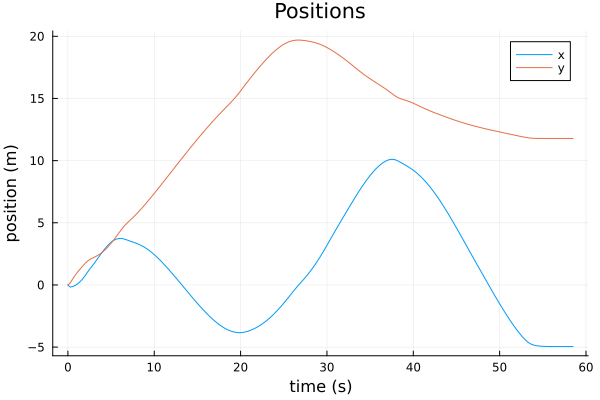

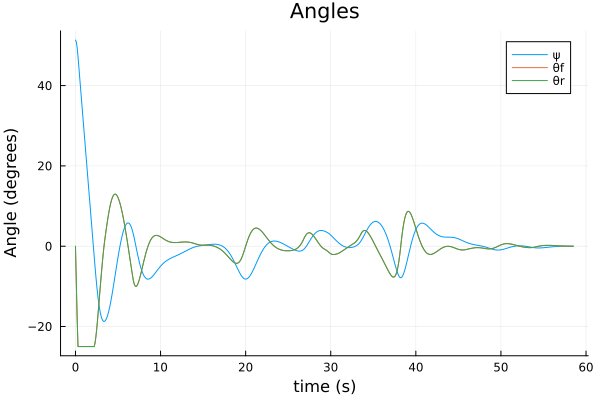

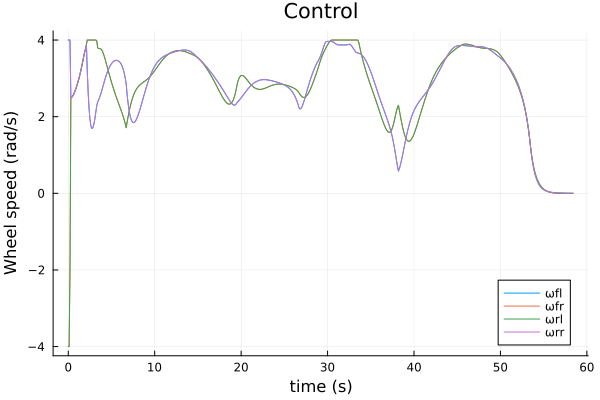

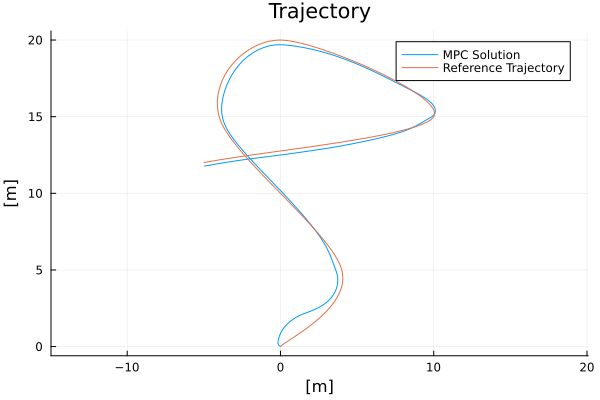

In [ ]:
# create our discrete time model 
# dt = 1.0
# A,B = create_dynamics(dt)

# states and controls 
Xref, Uref = generate_trajectory(points, input_params) #also try with X_dirc, U_dirc
# Xref = X_dirc
# Uref = U_dirc

nx = length(Xref[1])
nu = length(Uref[1])
N = length(Xref)

# MPC window size 
N_mpc = 50 
N_sim = N + N_mpc


# problem size 
tf = (N_sim-1)*dt #dt defined above
t_vec = 0:dt:tf 

# get our sizes for state and control
# nx,nu = size(B)

# initial and goal states
# x0 = [-2;-4;2;0;0;.0]
# xg = [0,-.68,3.05,0,0,0]
display("x0:")
x0 = Xref[1]
display(x0)

X_ref_pad = [Xref..., [Xref[N] for i in 1:N]...]  #pad out the end of the reference trajectory by the MPC Horizon
U_ref_pad = [Uref..., [Uref[N-1] for i in 1:N]...]  #pad out the end of the reference trajectory by the MPC Horizon

# bounds on U
u_max = 4*ones(nu)
u_min = -u_max

# problem size and reference trajectory 
# N = 100 
# t_vec = 0:dt:((N-1)*dt)
# X_ref = [desired_trajectory(x0,xg,N,dt)...,[xg for i = 1:N]...] 


# sim size and setup 
# N_sim = N + 20 # + N_mpc?
# t_vec = 0:dt:((N_sim-1)*dt)
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = x0 
U_sim = [zeros(nu) for i = 1:N_sim-1]

# simulate 
@showprogress "simulating" for i = 1:N_sim-1 
    
    # get state estimate
    # xi_estimate = state_estimate(X_sim[i], xg)
    xi_estimate = X_sim[i] #no noise for now

    # A = FD.jacobian(_x -> rk4(input_params, _x, U_dirc[k], dt),X_dirc[k])
    # B = FD.jacobian(_u -> rk4(input_params, X_dirc[k], _u, dt),U_dirc[k])
    A = FD.jacobian(_x -> rk4(input_params, _x, U_ref_pad[i], dt),X_ref_pad[i])
    B = FD.jacobian(_u -> rk4(input_params, X_ref_pad[i], _u, dt),U_ref_pad[i])
    
    # TODO: given a window of N_mpc timesteps, get current reference trajectory
    # X_ref_tilde = NaN
    
    ####
    X_ref_tilde = X_ref_pad[i:i+N_mpc-1]
    ####
    
    # TODO: call convex mpc controller with state estimate 
    
    ####
    u_mpc = convex_mpc(A, B, X_ref_tilde, xi_estimate, u_min, u_max, N_mpc)
    ####

    # commanded control goes into thruster model where it gets modified 
    # U_sim[i] = thruster_model(X_sim[i], xg, u_mpc)
    U_sim[i] = u_mpc #no noise for now
    
    # simulate one step 
    X_sim[i+1] = A*X_sim[i] + B*U_sim[i]
end

# -------------plotting/animation---------------------------
Xm = hcat(X_sim...)
Um = hcat(U_sim...)
display(plot(t_vec,Xm[1:2,:]',title = "Positions",
             xlabel = "time (s)", ylabel = "position (m)",
             label = ["x" "y"]))
display(plot(t_vec,Xm[3:end,:]' *180/pi,title = "Angles",
        xlabel = "time (s)", ylabel = "Angle (degrees)",
             label = ["ψ" "θf" "θr"]))
display(plot(t_vec[1:end-1],Um',title = "Control",
        xlabel = "time (s)", ylabel = "Wheel Speed (rad/s)",
             label = ["ωfl" "ωfr" "ωrl" "ωrr"]))

x_ref_pos = [Xref[i][1] for i in 1:length(Xref)]
y_ref_pos = [Xref[i][2] for i in 1:length(Xref)]

x_mpc_pos = [X_sim[i][1] for i in 1:length(X_sim)]
y_mpc_pos = [X_sim[i][2] for i in 1:length(X_sim)]

plot(x_mpc_pos, y_mpc_pos, label="MPC Solution", xlabel = "[m]", ylabel = "[m]",title = "Trajectory"; aspect_ratio=:equal)
display(plot!(x_ref_pos,y_ref_pos,label="Reference Trajectory"))


# display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))

In [106]:
println(size(X_sim))

θf = [X_sim[i][4] for i = 1:size(X,1)]

display(maximum(θf)*180/pi) #maximum axis angle acheived by front axle (radians)

12.962264714605373

(586,)
